In [1]:
import warnings
import os
display(os.getcwd())

'/home/jovyan'

In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import get_body
from astropy.time import Time

from astroplan.plots import plot_finder_image, plot_airmass
from astroplan import Observer, FixedTarget, time_grid_from_range

from astroquery.simbad import Simbad as simbad

## Building Functions 
###### (scroll down for lab portion)

#### 1. Establishing location and observing time for Kitt Peak Observatory
[calc_observation]: Sorting out observation window and making sense of the moon

In [25]:
def calc_observation(date, location):
    loc_noon = location.noon(date, which = "previous") # UTC datetime of noon at location
    loc_midnight = location.midnight(loc_noon, which='next')

    obs_night = location.tonight(loc_noon, horizon = 0*u.deg) # outputs [UTC datetime sunset, UTC datetime sunrise]
    obs_length = (obs_night[1] - obs_night[0]).to(u.h)
    obs_window = time_grid_from_range(obs_night, time_resolution = 0.1*u.h)

    print(f"Observation Window at {location.name}:",
        f"\n○ {obs_length:.1f} of observation time between",
        f"\n○ {obs_night[0].strftime('%b %d, %Y %H:%M')} and {obs_night[1].strftime('%b %d, %Y %H:%M')} UTC or",
        
        #apo.noon(project_date, which = "next").to_datetime(apo.timezone)
        f"\n○ {obs_night[0].to_datetime(location.timezone).strftime('%b %d, %Y %H:%M')} and {obs_night[1].to_datetime(location.timezone).strftime('%b %d, %Y %H:%M')} local time ({location.timezone})")
    print('')
    print(f"Potential Impacts of the Moon:",
          f"\n○ Illumination: {round(location.moon_illumination(loc_midnight) * 100, 2)}%", 
          f"\n○ Moon Phase: {(location.moon_phase(loc_noon).to(u.deg)):.2f}",
          f"\n○ Moon Rise Time: {location.moon_rise_time(loc_midnight, which='next').to_value('iso', 'date_hm')} {loc_midnight.scale}", 
          f"\n○ Moon Set Time: {location.moon_set_time(loc_midnight, which='next').to_value('iso', 'date_hm')} {loc_midnight.scale}")
    print('')
    print("Now returning loc_noon, loc_midnight, obs_night, obs_length, and obs_window.")
    
    return loc_noon, loc_midnight, obs_night, obs_length, obs_window

#### 2. Filtering out objects to narrow down the observation list
[filter_airmass]: First pass will filter out airmasses greater than 1.5

In [5]:
def filter_airmass(list, location, loc_midnight):
    targets_coord = []
    targets_name = []
    
    for object in list:
        try: 
            object_coords = FixedTarget.from_name(object)
            airmass = location.altaz(loc_midnight, object_coords).secz
        
            if abs(airmass) < 1.5:
                targets_coord.append(object_coords)
                targets_name.append(object)
            
        except Exception as e:
            print(f"{object} was skipped: {e}. \nContinuing with next iteration.")
            continue
    return targets_coord, targets_name

[filter_visible]: Second pass will filter out objects not visible during the observing window

In [6]:
def filter_visible(location, coordinate_list, window, name_list):
    count_index = 0
    cnt_true = 0
    time_seen = []
    names_visible = []
    names_limited = []

    for object in coordinate_list:
        for time in window: # goes through every time for one object at a time
            if location.target_is_up(time, coordinate_list[count_index]) == True:
                cnt_true = cnt_true + 1
                time_seen.append( Time(time, format = 'ymdhms') )
        
        if cnt_true == len(window):
            names_visible.append(name_list[count_index])
        elif len(time_seen) != 0:
            names_limited.append(name_list[count_index])
            print(f"{object.name} will only be visible between {min(time_seen).to_datetime(location.timezone).strftime('%H:%M')} and", 
                  f"{max(time_seen).to_datetime(location.timezone).strftime('%H:%M')} {window.scale}.")
    
        # preparing for next object
        count_index = count_index + 1
        cnt_true = 0
        time_seen = []

    return names_visible, names_limited

#### 3. Generating images for remaining interacting galaxies
Commenting out a test with one object

In [6]:
# object = coord.SkyCoord.from_name(data[0]['MAIN_ID'])

# fig, ax = plt.pyplot.subplots(
#     figsize = (2, 2), 
#     constrained_layout = True
# )

# ax, hdu = plot_finder_image(
#     object, 
#     fov_radius= 0.055 * u.deg, 
#     ax = ax,
#     survey = 'DSS2 Blue'
# )

# ax.imshow(hdu.data, 
#           cmap = plt.cm.magma,
#           origin = "lower", # sets origin to lower left corner
#           vmin = hdu.data.mean(),
#           vmax = np.max(hdu.data)
#          )

[show_objects]: Now displaying the remaining observable objects

In [7]:
def show_objects(nrows, ncols, figsize, names_list, *, cmap = plt.cm.magma):
    counter = 0
    
    fig, axs = plt.pyplot.subplots(nrows=nrows, ncols=ncols, figsize=figsize, 
                            subplot_kw={'xticks': [], 'yticks': []})
    
    for ax, name in zip(axs.flat, names_list):
        object = coord.SkyCoord.from_name(name)
        
        ax, hdu = plot_finder_image(
            object, 
            fov_radius= 0.04 * u.deg, 
            ax = ax,
            survey = 'DSS2 Blue'
        )
        
        ax.imshow(hdu.data, 
                  cmap = cmap,
                  vmin = hdu.data.mean(),
                  vmax = np.max(hdu.data),
                  aspect='auto'
                 )

        # x-axis is RA, y-axis is Dec -- just setting a bottom label
        ax.set_xlabel(f"RA: {np.ma.getdata(data[[counter]]['RA'])[0]}      Dec: {np.ma.getdata(data[[counter]]['DEC'])[0]}")
        ax.set_ylabel('')
        ax.set_title(f"#{counter+1}: {name}")
        counter = counter + 1
    
    #display(data['MAIN_ID', 'RA', 'DEC'].to_pandas().query('MAIN_ID in @names_list'))
    plt.pyplot.tight_layout(pad=0.03, h_pad=1.2, w_pad=0.3, rect=(0, 0, 0, 0))
    plt.pyplot.show()

## Lab 1 - Planning Observations
Select a particular kind of astronomical object (some possibilities, not exhaustive - 
quasars, galaxies, binary stars, supernovae, globular clusters, planetary nebulae). Find  
catalog that contains a fair number of these objects. When you have found it, use t e
rubric on Canvas to identify your observatory window.

### Write the object type and the catalog you’ll be using 
I will be using interacting galaxy objects from the Simbad database. Gathering the first 100 objects from Simbad query:

In [8]:
data = simbad.query_criteria(maintypes='IG')[0:100]
data[:5]

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
ESO 193-7,00 00 24.1,-49 04 23,5,5,8000.000,8000.000,90,D,,1989ESOLV.C......0L,0
ESO 118-4,04 08 19.0495,-61 16 05.539,14,14,1.743,1.584,90,C,O,2020yCat.1350....0G,0
ESO 113-51,01 31 07.5396,-60 29 37.357,14,14,0.332,0.287,90,A,O,2020yCat.1350....0G,0
ESO 337-13,19 11 07.9,-38 39 42,5,5,8000.000,8000.000,90,D,,1982ESO...C......0L,0
ESO 360-6,04 19 41.0,-36 26 51,5,5,8000.000,8000.000,90,D,,1982ESO...C......0L,0


<h3>Write your observatory assignment & observing window. What will the moon phase be? Will the moon interfere with your observations? <br>Explain your reasoning</br></h3>

Selecting Kitt Peak Observatory for an observation run on May 5th, 2024

In [9]:
date1 = Time("2024-05-05", format='iso', out_subfmt='date_hm')

kpo = Observer(latitude = (31 * u.deg) + (57 * u.arcmin) + (30.40 * u.arcsec), 
                      longitude = (-111 * u.deg) + (35 * u.arcmin) + (40.90 * u.arcsec),
                      timezone = 'America/Los_Angeles',   
                      name = "Kitt Peak Observatory"
                     )

In [10]:
run1 = calc_observation(date1, kpo)

Observation Window at Kitt Peak Observatory: 
○ 7.4 h of observation time between 
○ May 05, 2024 03:35 and May 05, 2024 11:00 UTC or 
○ May 04, 2024 20:35 and May 05, 2024 04:00 local time (America/Los_Angeles)

Potential Impacts of the Moon: 
○ Illumination: 11.09% 
○ Moon Phase: 134.24 deg 
○ Moon Rise Time: 2024-05-05 10:56 utc 
○ Moon Set Time: 2024-05-04 22:27 utc

Now returning loc_noon, loc_midnight, obs_night, obs_length, and obs_window.


The moon should not have much impact on the observing window - it will only be about 11% illuminated, as it is almost close to being in the new moon phase. Astroplan indicates phases by degrees between 0° and 180°(or π), where 0° represents a full moon and 180° represents a new moon. The moon phase is calculated to be 134.24 deg and will have less impacts on the observation window. 

<h3> </b>Using more than 20 objects (and less than 100) - determine which of your objects will be visible during your observing window.</b> </h3>
Upload your code & list to Canvas, and write an explanation of your process (If you have more than 10 objects that are visible, pick ten for the rest of the assignment).<br>
Your object list should have at least name, RA, and DEC for each object.

<b>Filtering through objects from the Simbad query:</b>

In [11]:
pass_one = filter_airmass(list(data['MAIN_ID']), kpo, run1[1])

print(len(pass_one[0]), len(pass_one[1])) # verifying filter worked and that the lists of names & coordinates are lined up

[RSG99b] 06009-7716 E was skipped: Unable to find coordinates for name '[RSG99b] 06009-7716 E' using https://cds.unistra.fr/cgi-bin/nph-sesame/A?%5BRSG99b%5D%2006009-7716%20E. 
Continuing with next iteration.
47 47


In [12]:
pass_two = filter_visible(kpo, pass_one[0], run1[4], pass_one[1])
pass_two[0]

['APG 171',
 'VV  747',
 'VV  774',
 'APG  32',
 '[EAD2001] HDFN J123652.88+621404.8',
 'TKRS  8710',
 'APG 277',
 'MCG+03-40-057']

<b>Double checking for moon interference:</b>

In [13]:
moon_kpo = get_body('moon', date1)

for name in pass_two[0]:
    display(name, coord.SkyCoord.from_name(name).separation(moon_kpo))

'APG 171'

<Angle 19.79392716 deg>

'VV  747'

<Angle 75.60920325 deg>

'VV  774'

<Angle 48.0574441 deg>

'APG  32'

<Angle 81.05567533 deg>

'[EAD2001] HDFN J123652.88+621404.8'

<Angle 82.62330477 deg>

'TKRS  8710'

<Angle 82.59154022 deg>

'APG 277'

<Angle 33.85084006 deg>

'MCG+03-40-057'

<Angle 38.318013 deg>

<b>Rendering images of visible objects during this observing window:</b>

/tmp/ipykernel_266/3533517207.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.pyplot.tight_layout(pad=0.03, h_pad=1.2, w_pad=0.3, rect=(0, 0, 0, 0))


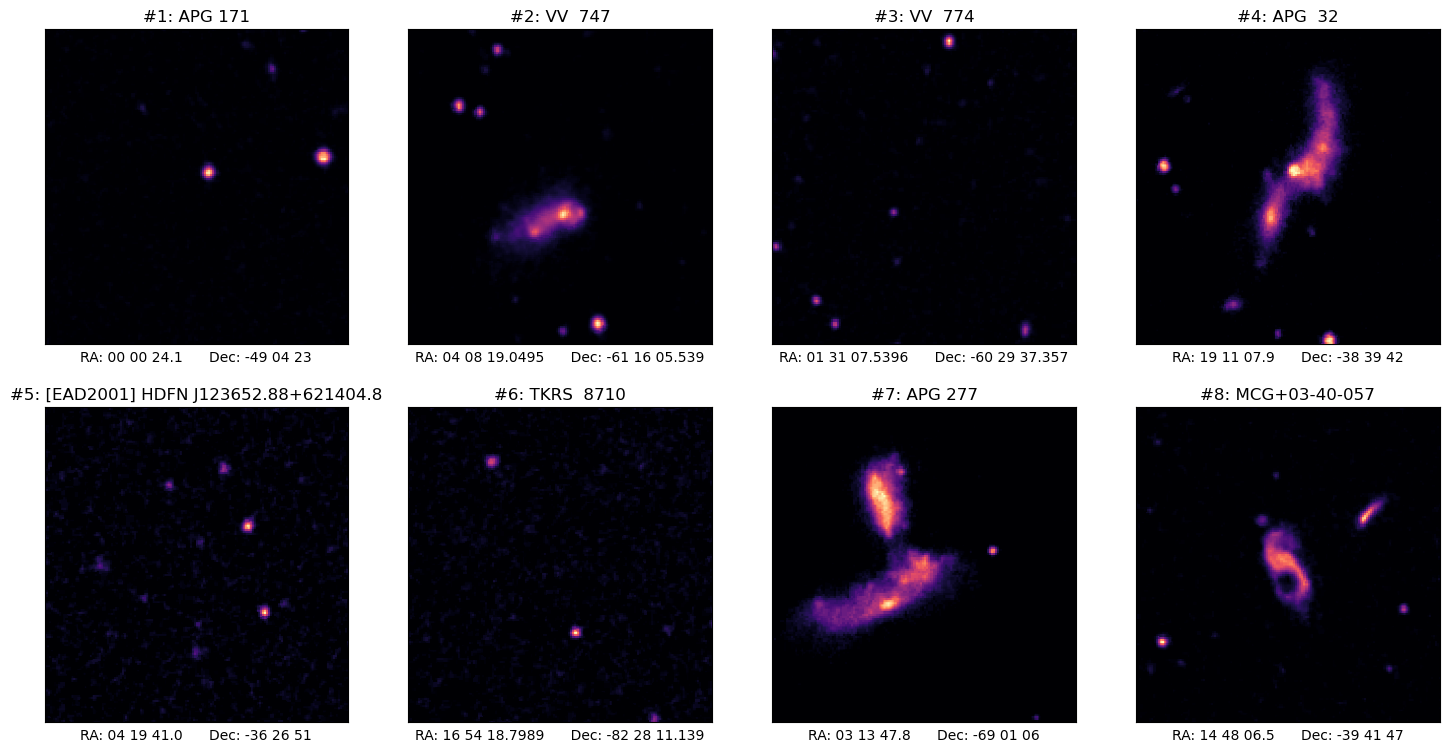

In [14]:
show_objects(
    nrows=2, ncols=4, 
    figsize = (18, 9), 
    names_list = pass_two[0])

### Observing 7 weeks later
Your observing run gets clouded out (a tragically common
occurance) but you’re able to get director’s discretionary time 7 weeks later.
Using the same objects you planned to observe initially - will it be better or
worse for your same ten objects? Explain

In [15]:
date2 = Time("2024-06-23", format='iso', out_subfmt='date_hm')
run2 = calc_observation(date2, kpo)

Observation Window at Kitt Peak Observatory: 
○ 6.4 h of observation time between 
○ Jun 23, 2024 04:11 and Jun 23, 2024 10:36 UTC or 
○ Jun 22, 2024 21:11 and Jun 23, 2024 03:36 local time (America/Los_Angeles)

Potential Impacts of the Moon: 
○ Illumination: 97.86% 
○ Moon Phase: 10.87 deg 
○ Moon Rise Time: 2024-06-23 03:49 utc 
○ Moon Set Time: 2024-06-23 13:33 utc

Now returning loc_noon, loc_midnight, obs_night, obs_length, and obs_window.


In [16]:
pass_one_later = filter_airmass(list(data['MAIN_ID']), kpo, run2[1])
len(pass_one_later[0]), len(pass_one_later[1])

[RSG99b] 06009-7716 E was skipped: Unable to find coordinates for name '[RSG99b] 06009-7716 E' using https://cds.unistra.fr/cgi-bin/nph-sesame/A?%5BRSG99b%5D%2006009-7716%20E. 
Continuing with next iteration.


(33, 33)

In [17]:
pass_two_later = filter_visible(kpo, pass_one_later[0], run2[4], pass_one_later[1])
pass_two_later[0]

['VV  774', 'APG  32', 'MCG+03-40-057']

In [18]:
# double checking for moon interference:
moon_kpo_later = get_body('moon', date2)

for name in pass_two_later[0]:
    display(name, coord.SkyCoord.from_name(name).separation(moon_kpo_later))

'VV  774'

<Angle 57.63428794 deg>

'APG  32'

<Angle 83.46838579 deg>

'MCG+03-40-057'

<Angle 52.98581834 deg>

<b>Objects that will be seen during the whole observing window:</b>

/tmp/ipykernel_266/3533517207.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.pyplot.tight_layout(pad=0.03, h_pad=1.2, w_pad=0.3, rect=(0, 0, 0, 0))


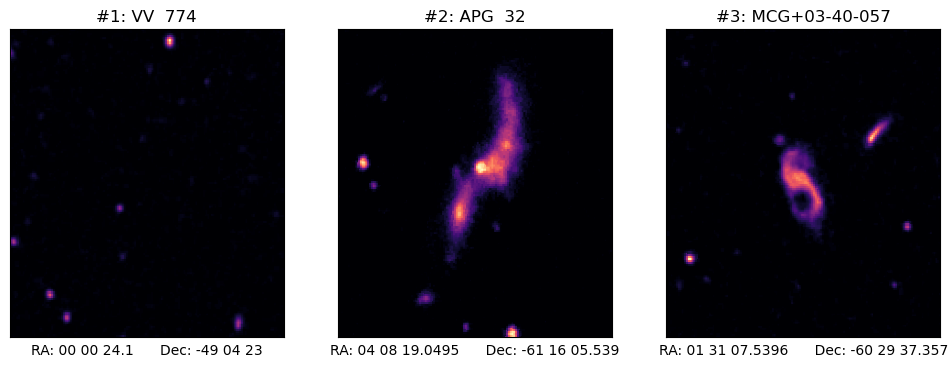

In [19]:
show_objects(
    nrows=1, ncols=3, 
    figsize=(12, 4), 
    names_list=pass_two_later[0])

<b>Comparing objects from May 5th, 2024 and June 23rd, 2024</b>

In [20]:
set(pass_two[0]) & set(pass_two_later[0])

{'APG  32', 'MCG+03-40-057', 'VV  774'}

For the 8 objects that are visible during the observation window at Kitt Peak Observatory on May 5th, 2024, APG 32, MCG+03-40-057, and VV 774 are the only objects that will also be visible during the observing window on June 23rd, 2024. These overlapping objects from May 5th, 2024 will also be visible during the entire observation window on June 23rd, 2024. So, for the interactiing galaxies that are visible from KPO on May 5th, 2024, it's a little worse since only 3/8 objects will be still be visible 7 weeks later.

## For Project Proposal (Dates: Apr 29 - May 9)
https://en.wikipedia.org/wiki/List_of_tz_database_time_zones

In [26]:
apo = Observer(latitude = (32 * u.deg) + (46 * u.arcmin) + (48.00 * u.arcsec), 
                      longitude = (105 * u.deg) + (49 * u.arcmin) + (12 * u.arcsec),
                      timezone = 'America/Denver', # utc-6 hours
                      name = "Apache Point Observatory"
                     )

project_date = Time("2024-04-30", format='iso', out_subfmt='date_hm') # time in UTC
local_time = project_date.to_datetime(apo.timezone)

project_run = calc_observation(project_date, apo)

# utc datetime sunset, sunrise
project_run[2][0].to_datetime(apo.timezone), project_run[2][1].to_datetime(apo.timezone)

Observation Window at Apache Point Observatory: 
○ 10.7 h of observation time between 
○ Apr 29, 2024 11:32 and Apr 29, 2024 22:14 UTC or 
○ Apr 29, 2024 05:32 and Apr 29, 2024 16:14 local time (America/Denver)

Potential Impacts of the Moon: 
○ Illumination: 69.19% 
○ Moon Phase: 61.26 deg 
○ Moon Rise Time: 2024-04-29 17:06 utc 
○ Moon Set Time: 2024-04-30 02:44 utc

Now returning loc_noon, loc_midnight, obs_night, obs_length, and obs_window.


(datetime.datetime(2024, 4, 29, 5, 32, 53, 693351, tzinfo=<DstTzInfo 'America/Denver' MDT-1 day, 18:00:00 DST>),
 datetime.datetime(2024, 4, 29, 16, 14, 39, 469568, tzinfo=<DstTzInfo 'America/Denver' MDT-1 day, 18:00:00 DST>))

In [17]:

#project_date.scale
apo.noon(project_date, which = "next").to_datetime(apo.timezone), type(project_date), local_time.time

(datetime.datetime(2024, 4, 29, 22, 53, 58, 367616, tzinfo=<DstTzInfo 'America/Denver' MDT-1 day, 18:00:00 DST>),
 astropy.time.core.Time,
 <function datetime.time>)

In [36]:
proj_p1 = filter_airmass(list(data['MAIN_ID']), apo, project_run[1])

proj_p2 = filter_visible(apo, proj_p1[0], project_run[4], proj_p1[1])
proj_p2[0]

[RSG99b] 06009-7716 E was skipped: Unable to find coordinates for name '[RSG99b] 06009-7716 E' using https://cds.unistra.fr/cgi-bin/nph-sesame/A?%5BRSG99b%5D%2006009-7716%20E. 
Continuing with next iteration.


['APG 171',
 'VV  747',
 'VV  774',
 'APG  32',
 '[PCD91] 1040+317 2',
 '[EAD2001] HDFN J123652.88+621404.8',
 'TKRS  8710',
 'APG 277',
 'MCG+03-40-057']

In [ ]:
moon_apo = get_body('moon', project_date)

for name in proj_p2[0]:
    display(name, coord.SkyCoord.from_name(name).separation(moon_apo))

show_objects(
    nrows=2, ncols=4, 
    figsize = (18, 9), 
    names_list = proj_p2[0])